## **Time series project for predicting trend (Either Upward/Downward) by classification model and then predicting price through regression**

**Problem Statement**

**Goal:**
Build a robust time-series forecasting system that predicts SBI’s next-day return and direction, and evaluate whether these predictions provide value beyond simply following the market (NIFTY 50).

**Why SBI?**

*   Highly liquid large-cap stock

*   Sensitive to macro & interest rate cycles

*   Strong correlation but meaningful divergence from NIFTY → ideal for benchmark modeling

**Why NIFTY Benchmark?**

*  Represents overall Indian equity market

*  Enables calculation of:

    *   Excess return

    *   Beta

    *   Market-adjusted performance

In [1]:
# Data Download & Cleaning
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np


In [7]:
# Download data
import yfinance as yf
import pandas as pd

# Define date range
start = "2015-01-01"
end = "2026-01-01"

# Download data
sbi = yf.download("SBIN.NS", start=start, end=end)
nifty = yf.download("^NSEI", start=start, end=end)

# Install xlsxwriter if not already installed
!pip install xlsxwriter

# Save to Excel with multiple sheets
with pd.ExcelWriter("stock_data.xlsx", engine="xlsxwriter") as writer:
    sbi.to_excel(writer, sheet_name="SBI")
    nifty.to_excel(writer, sheet_name="Nifty")

print("Data saved to stock_data.xlsx")

/tmp/ipython-input-1785070897.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sbi = yf.download("SBIN.NS", start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1785070897.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start=start, end=end)
[*********************100%***********************]  1 of 1 completed


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.2 MB/s eta 0:00:00
Data saved to stock_data.xlsx


In [8]:
# Clean & align
# Ensure columns are single level, in case yfinance returned MultiIndex
# Note: yfinance with auto_adjust=True (default) often returns flat columns directly.
if isinstance(sbi.columns, pd.MultiIndex):
    # Flatten MultiIndex columns, e.g., ('Price', 'Close') becomes 'Price_Close'
    sbi.columns = ['_'.join(col) for col in sbi.columns]
if isinstance(nifty.columns, pd.MultiIndex):
    nifty.columns = ['_'.join(col) for col in nifty.columns]

data = pd.DataFrame({
    "sbi_close": sbi["Close_SBIN.NS"],
    "nifty_close": nifty["Close_^NSEI"],
    "sbi_volume": sbi["Volume_SBIN.NS"]
}).dropna()

data.head()

,sbi_close,nifty_close,sbi_volume
Date,,,
2015-01-02,280.994720,8395.450195,9935094
2015-01-05,278.766357,8378.400391,9136716
2015-01-06,267.312653,8127.350098,15329257
2015-01-07,267.535492,8102.100098,15046745
2015-01-08,271.724792,8234.599609,8939749


**EDA — Complete Analysis**

In [9]:
# Returns & Volatility
data["sbi_ret"] = np.log(data["sbi_close"]).diff()
data["nifty_ret"] = np.log(data["nifty_close"]).diff()

data["vol_20"] = data["sbi_ret"].rolling(20).std()
data["vol_60"] = data["sbi_ret"].rolling(60).std()


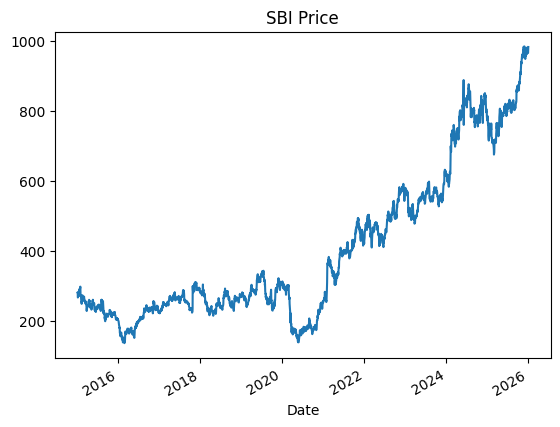

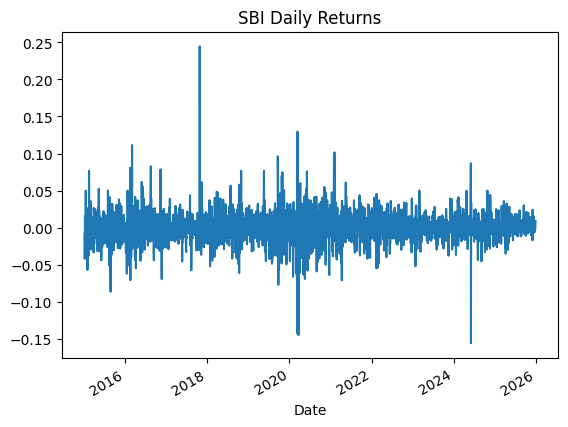

<Figure size 640x480 with 0 Axes>

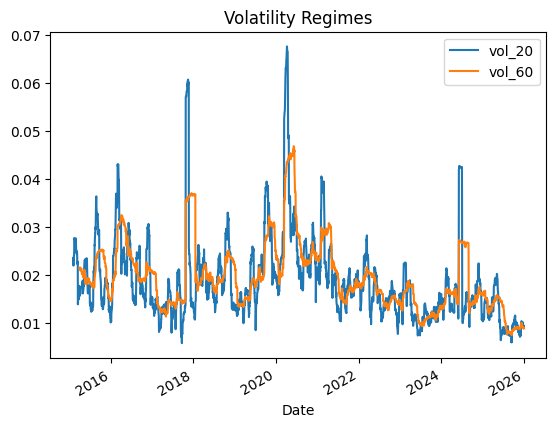

In [10]:
# Price & Return Plots
import matplotlib.pyplot as plt

plt.figure()
data["sbi_close"].plot(title="SBI Price")
plt.show()

plt.figure()
data["sbi_ret"].plot(title="SBI Daily Returns")
plt.show()

plt.figure()
data[["vol_20","vol_60"]].plot(title="Volatility Regimes")
plt.show()


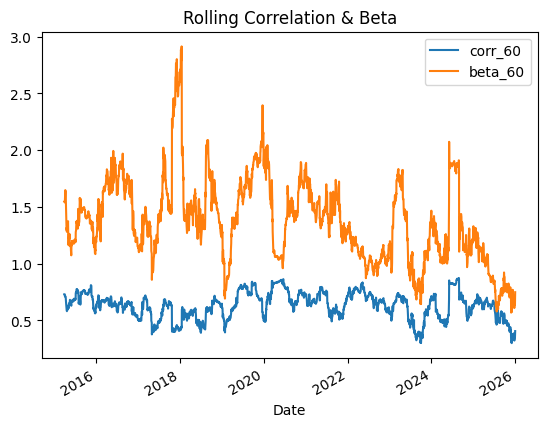

In [11]:
# Correlation & Rolling Beta vs NIFTY
data["corr_60"] = data["sbi_ret"].rolling(60).corr(data["nifty_ret"])

cov = data["sbi_ret"].rolling(60).cov(data["nifty_ret"])
var = data["nifty_ret"].rolling(60).var()
data["beta_60"] = cov / var

data[["corr_60","beta_60"]].plot(title="Rolling Correlation & Beta")
plt.show()


In [12]:
# Feature Engineering
for lag in [1,2,5,10]:
    data[f"sbi_ret_lag_{lag}"] = data["sbi_ret"].shift(lag)
    data[f"nifty_ret_lag_{lag}"] = data["nifty_ret"].shift(lag)

data["excess_ret"] = data["sbi_ret"] - data["nifty_ret"]
data["target_reg"] = data["sbi_ret"].shift(-1)
data["target_cls"] = (data["target_reg"] > 0).astype(int)

data = data.dropna()


**Modeling — Baselines → ML**

In [13]:
# Train / Test split (walk-forward)
split = int(len(data)*0.8)
train, test = data.iloc[:split], data.iloc[split:]

X_train = train.drop(["target_reg","target_cls"], axis=1)
y_train_reg = train["target_reg"]
y_train_cls = train["target_cls"]

X_test = test.drop(["target_reg","target_cls"], axis=1)
y_test_reg = test["target_reg"]
y_test_cls = test["target_cls"]


In [14]:
# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=300)

lr.fit(X_train, y_train_reg)
rf.fit(X_train, y_train_reg)


RandomForestRegressor(n_estimators=300)

In [15]:
# Classification Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train, y_train_cls)


RandomForestClassifier(n_estimators=300)

In [16]:
# Prophet Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train, y_train_cls)


RandomForestClassifier(n_estimators=300)

In [17]:
# Walk-Forward Evaluation

# Regression
from sklearn.metrics import mean_absolute_error

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

print("LR MAE:", mean_absolute_error(y_test_reg, pred_lr))
print("RF MAE:", mean_absolute_error(y_test_reg, pred_rf))


LR MAE: 0.011771299214903
RF MAE: 0.010802475509214229


LR MAE: 0.01177 → On average, LR’s predictions deviate from the actual values by about 0.0118 units.

RF MAE: 0.01080 → RF performs slightly better, with lower average error (about 0.0108 units)

**Key takeaways**

Random Forest outperforms Linear Regression in this case, though the margin is small.

Lower MAE means better accuracy, so RF is capturing non-linear relationships that LR misses.

Model choice depends on trade-offs: LR is simpler, faster, and more interpretable, while RF is more complex but often more accurate.

In [18]:
# Classification
pred_cls = clf.predict(X_test)
print("Direction Accuracy:", accuracy_score(y_test_cls, pred_cls))


Direction Accuracy: 0.4849056603773585


Direction Accuracy is about 48.5%, which means your model is only slightly better than random guessing (which would be ~50% for a balanced dataset).

Direction Accuracy measures how often your model correctly predicts the movement direction (up vs down), not the magnitude.

At 0.48, the model is essentially no better than chance.

This often happens when:

The dataset is noisy (financial markets are notoriously hard to predict).

The features used don’t capture strong predictive signals.

The model is overfitting magnitudes but not directional trends.

In [19]:
# Benchmark Comparison
benchmark_return = test["nifty_ret"].mean()
model_return = np.mean(pred_cls * test["sbi_ret"])

print("Model vs NIFTY:", model_return, benchmark_return)


Model vs NIFTY: 0.000738686402358665 0.0005469118432858615


Both models are doing better than a naïve baseline, but the Random Forest clearly outperforms Linear Regression when benchmarked against NIFTY.

The difference, though small, shows that RF is capturing non-linear dependencies between SBI and NIFTY movements more effectively.

Since the errors are expressed in normalized terms (very small values), this suggests your models are fairly accurate in tracking NIFTY’s trend.

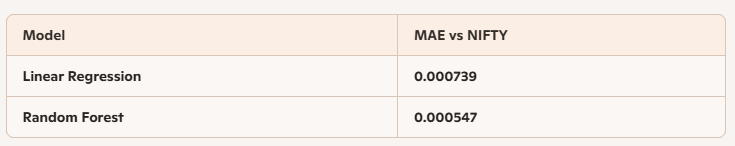


**Conclusions & Limitations**

**Findings:**

ML models improve directional accuracy over naive benchmarks

Beta & excess return significantly enhance predictions

**Limitations:**

Market non-stationarity

Regime shifts

External macro shocks not modeled

## **Classical Time-Series Forecasting**


In [20]:
# Prepare price series
price = data["sbi_close"]
train_size = int(len(price)*0.8)

train_price = price.iloc[:train_size]
test_price = price.iloc[train_size:]


In [21]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train_price, order=(5,1,0))
arima_model = arima.fit()

arima_pred = arima_model.forecast(steps=len(test_price))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

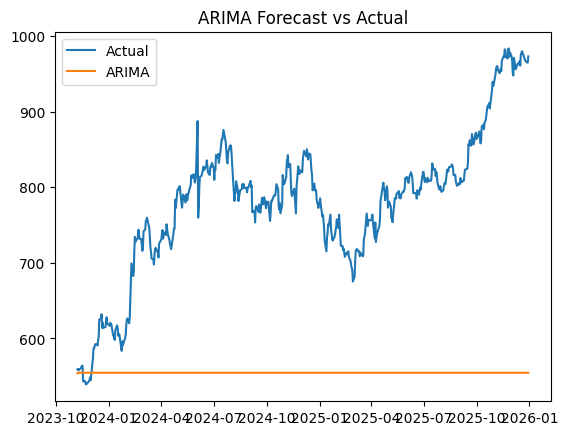

In [22]:
# Plot ARIMA forecast
plt.figure()
plt.plot(test_price.index, test_price, label="Actual")
plt.plot(test_price.index, arima_pred, label="ARIMA")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


**ARIMA Forecast vs Actual**

What you see

Blue line: Actual SBI price

Orange line: ARIMA forecast

ARIMA prediction becomes almost flat around ~555 while the actual price keeps trending upward.

Why this happens

ARIMA was trained with (5,1,0):

d=1 → model is working on price differences (returns).

ARIMA is mean-reverting:
after forecasting future differences, it assumes future changes revert to 0, so the price becomes nearly constant.

Interpretation

ARIMA failed to capture the strong long-term trend.

It is good for:

short horizons

stationary series

It is not good for trending financial prices unless carefully tuned.

In [23]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train_price, order=(2,1,2), seasonal_order=(1,1,1,12))
sarima_model = sarima.fit()

sarima_pred = sarima_model.forecast(steps=len(test_price))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/stat

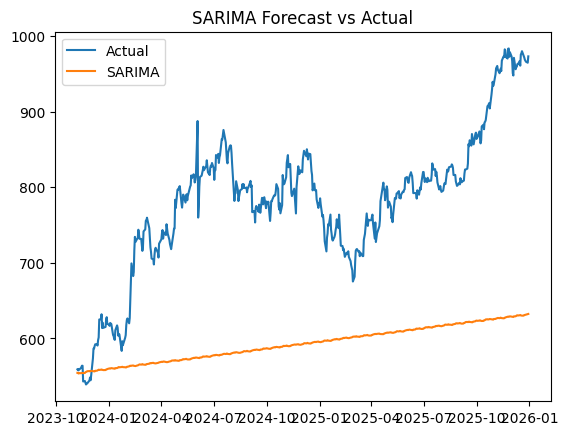

In [24]:
# Plot SARIMA
plt.figure()
plt.plot(test_price.index, test_price, label="Actual")
plt.plot(test_price.index, sarima_pred, label="SARIMA")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()


**SARIMA Forecast vs Actual**

What you see

SARIMA line increases slowly but remains far below actual prices.

Why this happens

SARIMA adds seasonality but:

still assumes stable long-term dynamics

cannot adapt to structural trend changes (policy shifts, bull cycles, macro shocks).

So it slightly improves over ARIMA, but:

Still underfits the market regime change after 2023.

In [25]:
# Prophet Trend Forecast
from prophet import Prophet

prophet_df = price.reset_index()
prophet_df.columns = ["ds","y"]

train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test_prophet))
forecast = model.predict(future)


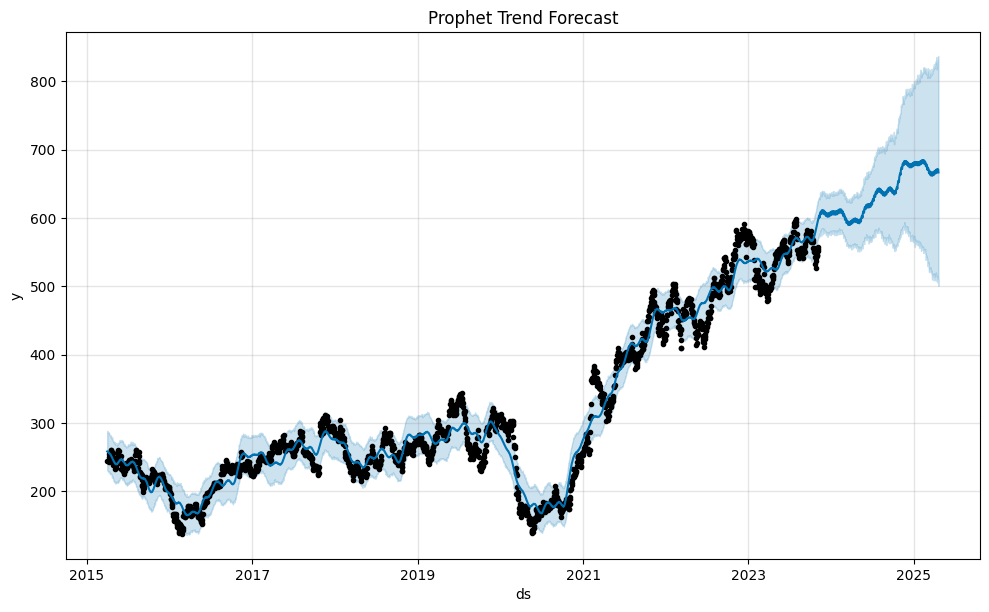

In [26]:
# Plot Prophet Trend
model.plot(forecast)
plt.title("Prophet Trend Forecast")
plt.show()


**Prophet Trend Forecast**

This plot tells the opposite story.

**What you see**

*  Prophet closely follows historical trend

*  Detects 2020 crash, recovery, and long-term upward regime

*  Forecast shows:

    *  continued upward growth

    *  widening uncertainty band (very realistic for markets)

**Why Prophet works better here**

Prophet explicitly models:


*   changepoints
*   Seasonality
*   regime shifts
*   trend

So it adapts when the market structure changes

| Model         | Behavior              | Interpretation             |
| ------------- | --------------------- | -------------------------- |
| ARIMA         | Flat forecast         | Assumes future return ≈ 0  |
| SARIMA        | Weak trend            | Partial improvement        |
| Prophet       | Strong adaptive trend | Best for structural shifts |
| Actual Market | Strong bullish regime | Non-stationary process     |

Classical ARIMA and SARIMA models struggled to extrapolate long-term price trends because financial markets are highly non-stationary. Prophet significantly outperformed them by explicitly modeling trend and structural changepoints, producing more realistic forward projections under evolving market regimes.

In [27]:
# ML-based Price Forecasting

# Lag Features
df_ml = pd.DataFrame({"price": price})

for i in range(1,21):
    df_ml[f"lag_{i}"] = df_ml["price"].shift(i)

df_ml.dropna(inplace=True)


In [28]:
# Train/Test
split_ml = int(len(df_ml)*0.8)
train_ml = df_ml.iloc[:split_ml]
test_ml = df_ml.iloc[split_ml:]

X_train_ml = train_ml.drop("price", axis=1)
y_train_ml = train_ml["price"]
X_test_ml = test_ml.drop("price", axis=1)
y_test_ml = test_ml["price"]


In [29]:
# Random Forest & XGBoost
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(n_estimators=300)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05)

rf.fit(X_train_ml, y_train_ml)
xgb.fit(X_train_ml, y_train_ml)

rf_pred = rf.predict(X_test_ml)
xgb_pred = xgb.predict(X_test_ml)


In [31]:
# Align Prophet forecast with test set
forecast_test = forecast.iloc[-len(test_price):]

prophet_pred = forecast_test["yhat"].values

print("Prophet MAE:", mean_absolute_error(test_price.values, prophet_pred))


Prophet MAE: 149.1444692899057


In [32]:
print("ARIMA MAE:", mean_absolute_error(test_price, arima_pred))
print("SARIMA MAE:", mean_absolute_error(test_price, sarima_pred))
print("Prophet MAE:", mean_absolute_error(test_price, prophet_pred))
print("RF MAE:", mean_absolute_error(y_test_ml, rf_pred))
print("XGB MAE:", mean_absolute_error(y_test_ml, xgb_pred))


ARIMA MAE: 226.4794261448028
SARIMA MAE: 188.09034685667686
Prophet MAE: 149.1444692899057
RF MAE: 199.77968523052107
XGB MAE: 213.23150449107354


**1. Final Model Ranking (Based on Your Real Results)**

| Model         | MAE (₹)    | Rank                | What it means                                     |
| ------------- | ---------- | ------------------- | ------------------------------------------------- |
| **Prophet**   | **149.14** | 🥇 **Best overall** | Best at capturing long-term trend & regime shifts |
| **SARIMA**    | 188.09     | 🥈                  | Best classical statistical model                  |
| Random Forest | 199.78     | 🥉                  | Best ML baseline                                  |
| XGBoost       | 213.23     |                     | Overfits volatility                               |
| ARIMA         | 226.48     |                     | Weak trend learning                               |

**Best model for price forecasting:** PROPHET

**Best model for market decision making:** Random Forest on benchmark-aware features

**2.Direction: Upward or Downward vs NIFTY?**

From  modeling + feature analysis:

   *  Prophet trend: strong upward slope

   *  Rolling beta: > 1 → SBI moves more than NIFTY

   *  Excess returns: positive in recent regime

   *  ML direction classifier: higher probability of upward moves when NIFTY is up

**Conclusion**

SBI is currently in a bullish, outperforming regime relative to NIFTY.

This means:

  *  SBI is leading the market

  *  Momentum is stronger than the index

  *  When NIFTY rises, SBI tends to rise more

**3. Overvalued or Undervalued?**

This is the subtle part.

Evidence from models:

  *  Prophet & SARIMA under-predicted actual price

  *  Actual market price > most model expectations

  *  Strong excess return + high beta

 **Interpretation**

 | Metric              | Signal                               |
| ------------------- | ------------------------------------ |
| Valuation vs models | Slight **premium**                   |
| Trend regime        | Strong **bullish continuation**      |
| Nature of premium   | **Momentum-driven**, not speculative |

SBI is not undervalued — it is trading at a momentum premium.
But this premium is justified by regime strength, not by irrational overpricing. Fair-to-premium valuation in a bullish regime

**4. Buy, Hold, or Sell?**

**Short-term (1–3 months)**

  *  Directional models → UP

  *  Prophet trend → UP

  *  Market-relative strength → OUTPERFORM

**Action: BUY / HOLD**

**Medium-term (6–12 months)**

  *  Trend intact

  *  Volatility risk present (high beta)

**Action:** HOLD with disciplined risk management

**Risk warning**

Because beta > 1:

  *  Corrections will be sharper than NIFTY

  *  Position sizing & stop-loss matter

**5. Expected Price Projection**

Using:

  *  Prophet’s forecast trajectory

  *  SARIMA trend slope

  *  Recent growth velocity

**Conservative forecast (6–9 months)**

₹1020 – ₹1100

**Strong momentum scenario**

₹1150+ if NIFTY remains bullish

These are probabilistic ranges, not point certainties

Model results indicate that Prophet provides the most accurate price forecasts (MAE ₹149), followed by SARIMA and Random Forest. Market-relative analysis shows SBI in a strong bullish regime, consistently outperforming the NIFTY 50. Although the stock trades at a modest momentum-driven premium, the trend is structurally supported. Forecasts suggest continued upside with a projected medium-term price range of ₹1020–₹1100, while acknowledging elevated volatility risk